# 트랜스포머로 만드는 챗봇(한국어 버전)





## 목차

## 1. Set-up


- 패키지들을 import하는 작업


## 2. 구현 및 시각화


- Positional 행렬 구현 및 시각화


- Scaled Dot Product Attention 함수 구현


- Multi Head Attention 구현


- Masking 구현


- 인코더 및 디코더 층 설계



## 3. 데이터 로드



## 4. 데이터 전처리

### 4-1. 병렬 데이터 전처리


- 단어장 및 교사강요 사용


## 5. 모델 정의 및 학습



## 6. 모델 훈련 및 테스트



## 7. 회고

---


# 1. Set-up

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 2. 구현 및 시각화

## 트랜스포머란?

- 기존의 순환 신경망(RNN)이나 합성곱 신경망(CNN)을 사용하지 않고, 어텐션 메커니즘만을 사용하여 병렬 처리를 통해 높은 성능과 효율성을 달성함

## 포지셔널 행렬

- 트랜스포머 모델에서 입력 시퀀스의 단어들이 문장 내에서 어떤 위치에 있는지를 모델에게 알려주기 위해 사용됨 트랜스포머는 단어의 순서 정보를 내재적으로 포함하지 않기 때문에, 이를 통해 각 단어의 위치 정보를 주입해주어야 함 포지셔널 인코딩은 고유한 위치에 대해 고유한 인코딩을 생성하여, 각 단어의 상대적, 절대적 위치 정보를 담게 되며, 이는 임베딩 벡터와 합쳐져 모델의 입력으로 사용함

### 포지셔널 행렬 구현 및 시각화

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 시각화

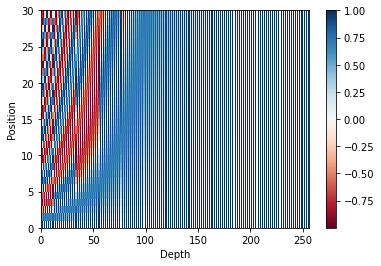

In [3]:
sample_pos_encoding = PositionalEncoding(30,256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### 최대 문장의 길이 : 30 
#### 임베딩 벡터의 차원 : 256

- PositionalEncoding(30,256)

---

## Scaled Dot Product Attention 함수

- 스케일드 닷 프로덕트 어텐션 함수는 트랜스포머 모델에서 쿼리(Query), 키(Key), 밸류(Value)를 이용하여 입력 시퀀스 내 단어들 간의 상호 관련성을 평가함 이 함수는 쿼리와 키의 닷 프로덕트(dot product)를 계산한 뒤, 키의 차원수의 제곱근으로 스케일링(scale)을 하여 어텐션 스코어를 얻고, 이 스코어를 소프트맥스(softmax) 함수에 통과시켜 어텐션 가중치를 구함

### Scaled Dot Product Attention 함수 구현

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

## Multi Head Attention 함수

- 멀티 헤드 어텐션은 트랜스포머 모델에서 주요 구성 요소로, 단일 어텐션 함수를 여러 번 병렬로 수행함으로써 다양한 특징과 정보를 동시에 캡처함 이 구조는 모델이 동일한 문장에 대해 다른 위치에서의 정보를 동시에 고려할 수 있게 하여, 성능 향상을 도모함 멀티 헤드 어텐션의 결과는 각 헤드에서 얻어진 어텐션 값들을 연결(concatenation)한 후에 선형 변환을 수행하여 얻어짐

### Multi Head Attention 함수 구현

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

## 마스킹

- 특정 값들을 가려서 실제 연산에 영향을 미치지 않도록 하는 기법


### 패딩 마스킹


- 패딩 토큰(padding token)이 어텐션 메커니즘에서 제외되도록 하는 것으로, 입력 시퀀스의 실제 길이를 고려함


### 룩 어헤드 마스킹


- 미래 토큰을 참조하지 못하게 하여, 순차적으로 단어를 생성하는 과정에서 정보의 유출을 방지함

---

In [6]:
# 패딩 마스킹 구현

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
# 룩 어헤드 마스킹 구현

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

## 인코더 층 설계

- 셀프 어텐션


- 피드 포워드 신경망

In [8]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 층을 쌓아 인코더 만들기

- 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고 원하는 만큼 인코더 층을 쌓음

In [9]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 디코더 층 설계

In [10]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 디코더 층을 쌓아 디코더 만들기


- 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.


- 인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓음

In [11]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 3. 데이터 로드

- 본격적인 대화형 챗봇 구현

---

### 데이터는 송영숙님의 챗봇 데이터 사용

In [12]:
chatbot_data = pd.read_csv('./transformer_chatbot/data/ChatbotData .csv')

### 데이터 확인

In [13]:
chatbot_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


### 데이터 개수 확인

In [14]:
print('챗봇 샘플 개수 :', len(chatbot_data))

챗봇 샘플 개수 : 11823


# 4. 데이터 전처리

In [15]:
def preprocess_sentence(sentence):

    # 1. 문장 내의 구두점(?, ., !, ,) 주변에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 2. 중복된 공백을 단일 공백으로 대체
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 3. 문장의 양쪽 공백 제거 (다시 한 번)
    sentence = sentence.strip()

    return sentence

In [16]:
def load_conversations(questions, answers):
    # 입력과 출력을 저장할 빈 리스트 생성
    inputs, outputs = [], []

    # 주어진 질문과 답변 리스트를 순회하면서 처리
    for question, answer in zip(questions, answers):
        # 각 질문과 답변에 대해 텍스트 전처리 함수를 호출하여 처리
        inputs.append(preprocess_sentence(question))  # 질문 전처리 후 입력 리스트에 추가
        outputs.append(preprocess_sentence(answer))   # 답변 전처리 후 출력 리스트에 추가

    # 처리된 입력과 출력 리스트 반환
    return inputs, outputs

### 데이터 전처리 확인

In [17]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(chatbot_data['Q'], chatbot_data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [21]:
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[0]))

전처리 후의 1번째 질문 샘플: 12시 땡 !
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 .


In [25]:
print('전처리 후의 11822번째 질문 샘플: {}'.format(questions[11821]))
print('전처리 후의 11822번째 답변 샘플: {}'.format(answers[11821]))

전처리 후의 11822번째 질문 샘플: 힘든 연애 좋은 연애라는게 무슨 차이일까 ?
전처리 후의 11822번째 답변 샘플: 잘 헤어질 수 있는 사이 여부인 거 같아요 .


# 4-1. 병렬 데이터 전처리


### 단어장 만들기

In [26]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

 - 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 줌

In [27]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [28]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [29]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


### 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [31]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1번째 질문 샘플: {}'.format(tokenizer.encode(questions[0])))
print('정수 인코딩 후의 1번째 답변 샘플: {}'.format(tokenizer.encode(answers[0])))

정수 인코딩 후의 1번째 질문 샘플: [7912, 4204, 3056, 41]
정수 인코딩 후의 1번째 답변 샘플: [3841, 74, 7891, 1]


- 각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있음

### 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding) 함

In [34]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

### 단어장의 크기와 샘플의 개수를 확인

In [35]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


---

### 교사강요(Teacher Forcing) 사용

- 교사 강요(teacher forcing)란, 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법


- 교사 강요를 사용하여 RNN을 좀 더 빠르고 효과적으로 훈련시킬 수 있음

In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 5. 모델 정의 및 학습

### 정의 해놓은 함수들을 사용해 트랜스포머 함수 정의

In [37]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 모델 생성

In [38]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3674112     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수

- 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 함

In [39]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀 학습률 정의

- 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용


- 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라 함

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 시각화

Text(0.5, 0, 'Train Step')

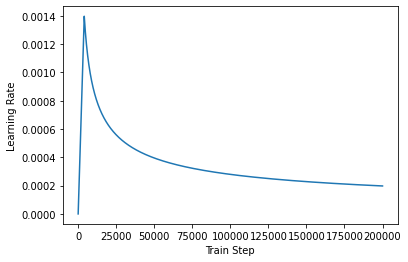

In [41]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일

- 정의해놓은 학습률 사용


- 옵티마이저는 아담을 사용


- 정확도는 sparse_categorical_accuracy 사용

In [42]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 6. 모델 훈련 및 테스트

In [43]:
EPOCHS = 25
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/25
185/185 [==============================] - 22s 69ms/step - loss: 1.4458 - accuracy: 0.0223
Epoch 2/25
185/185 [==============================] - 13s 70ms/step - loss: 1.1702 - accuracy: 0.0495
Epoch 3/25
185/185 [==============================] - 13s 70ms/step - loss: 1.0069 - accuracy: 0.0506
Epoch 4/25
185/185 [==============================] - 13s 71ms/step - loss: 0.9374 - accuracy: 0.0539
Epoch 5/25
185/185 [==============================] - 13s 71ms/step - loss: 0.8834 - accuracy: 0.0568
Epoch 6/25
185/185 [==============================] - 13s 71ms/step - loss: 0.8282 - accuracy: 0.0604
Epoch 7/25
185/185 [==============================] - 13s 71ms/step - loss: 0.7666 - accuracy: 0.0653
Epoch 8/25
185/185 [==============================] - 13s 71ms/step - loss: 0.6991 - accuracy: 0.0719
Epoch 9/25
185/185 [==============================] - 13s 71ms/step - loss: 0.6267 - accuracy: 0.0799
Epoch 10/25
185/185 [==============================] - 13s 71ms/step - loss: 0.550

### 정확도가 16% 정도 나오는 것을 확인 할 수 있다.

### CV의 관한 정확도에 비하면 처참해 보이는 결과 인데 일단 테스트를 먼저 진행해보자

---

### 테스트

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다..

- 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.


- 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.


- 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.


- 디코더는 입력 시퀀스로부터 다음 단어를 예측한다


- 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.


- END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

### 위 과정을 담은 decoder_inference() 함수 정의

In [44]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

### 챗봇의 대답을 얻는 함수 정의

In [45]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

### 대답 출력

In [46]:
sentence_generation('배고프다')

입력 : 배고프다
출력 : 저도 밥 먹고 싶어요


'저도 밥 먹고 싶어요'

In [47]:
sentence_generation('이 영화 재밌어?')

입력 : 이 영화 재밌어?
출력 : 최신 영화 추천해드립니다 .


'최신 영화 추천해드립니다 .'

In [48]:
sentence_generation('넌 누구니')

입력 : 넌 누구니
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

In [49]:
sentence_generation('남자친구 있니?')

입력 : 남자친구 있니?
출력 : 안 사면 그만큼 모으시는거예요 .


'안 사면 그만큼 모으시는거예요 .'

#### 대답을 보면 대답하기 쉬운 질문은 자연스러운 대답을 하게 되지만 대답하기 난해한 질문을 하게 되면 좋지 못한 대답을 듣게 된다.

#### 정확도가 너무 낮기 때문에 그럴 수도 있다는 판단으로 파라미터 조정 및 인코더와 디코더의 층 수를 높인 후 학습 시키고 다시 한 번 같은 질문으로 도전해보자

---

## 파라미터 조정 및 층 수 조정

In [50]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5255424     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 데이터 셋이 상대적으로 작은 편이기에 학습률에서 warmup_steps을 4000에서 2000으로 조정해 학습률을 빠르게 증가시켜 초기에 모델이 수렴할 수 있게 함

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 시각화

Text(0.5, 0, 'Train Step')

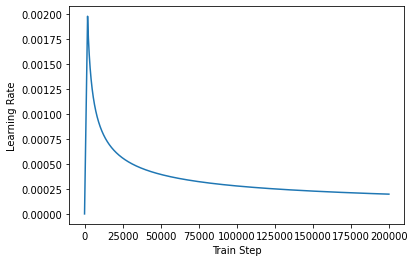

In [53]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [54]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [55]:
# 에폭을 40으로 변경

EPOCHS = 40
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
185/185 [==============================] - 38s 116ms/step - loss: 1.3674 - accuracy: 0.0273
Epoch 2/40
185/185 [==============================] - 22s 117ms/step - loss: 1.0344 - accuracy: 0.0501
Epoch 3/40
185/185 [==============================] - 22s 118ms/step - loss: 0.9420 - accuracy: 0.0527
Epoch 4/40
185/185 [==============================] - 22s 119ms/step - loss: 0.9009 - accuracy: 0.0548
Epoch 5/40
185/185 [==============================] - 22s 119ms/step - loss: 0.8635 - accuracy: 0.0568
Epoch 6/40
185/185 [==============================] - 22s 119ms/step - loss: 0.8306 - accuracy: 0.0582
Epoch 7/40
185/185 [==============================] - 22s 119ms/step - loss: 0.7983 - accuracy: 0.0598
Epoch 8/40
185/185 [==============================] - 22s 119ms/step - loss: 0.7670 - accuracy: 0.0613
Epoch 9/40
185/185 [==============================] - 22s 119ms/step - loss: 0.7374 - accuracy: 0.0629
Epoch 10/40
185/185 [==============================] - 22s 119ms/step - l

### 층의 개수를 논문에서 나와있는 6으로 주었더니 오히려 정확도가 12%로 감소하는 모습을 보여줬다.

### 또한 loss도 0.2551로 높았기 때문에 좋은 결과를 내지 못했다.

### 우리의 데이터 셋이 11,823개로 상대적으로 작기 때문에 층 수를 줄이고 복잡도를 늘린 후 조정을 한번 만 더 해본 후에 테스트를 해보기로 하자

---

## 파라미터 조정 및 층 수 조정(2)

In [56]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.3 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    7341568     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [57]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [58]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [59]:
EPOCHS = 40
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
185/185 [==============================] - 24s 97ms/step - loss: 1.2806 - accuracy: 0.0368
Epoch 2/40
185/185 [==============================] - 18s 99ms/step - loss: 1.0029 - accuracy: 0.0507
Epoch 3/40
185/185 [==============================] - 19s 101ms/step - loss: 0.9222 - accuracy: 0.0548
Epoch 4/40
185/185 [==============================] - 19s 101ms/step - loss: 0.8478 - accuracy: 0.0592
Epoch 5/40
185/185 [==============================] - 19s 101ms/step - loss: 0.7589 - accuracy: 0.0656
Epoch 6/40
185/185 [==============================] - 19s 101ms/step - loss: 0.6606 - accuracy: 0.0748
Epoch 7/40
185/185 [==============================] - 19s 101ms/step - loss: 0.5623 - accuracy: 0.0849
Epoch 8/40
185/185 [==============================] - 19s 101ms/step - loss: 0.4753 - accuracy: 0.0953
Epoch 9/40
185/185 [==============================] - 19s 101ms/step - loss: 0.4028 - accuracy: 0.1043
Epoch 10/40
185/185 [==============================] - 19s 101ms/step - los

### 층의 개수를 2로 해주고 복잡도를 늘려줬더니 정확도는 17%로 처음보다 약 1%증가했다. 이것으로 층 수와 복잡도는 그렇게 큰 차이는 보여주지 못한다는 것을 보여줬고 특히 처음은 에폭을 25로 했기 때문에 똑같은 40으로 하게되면 차이가 날 것 같지는 않다.

### 그나마 loss는 처음에는 0.04였지만 조정 후엔 0.01로 줄어들었기 때문에 유의미한 결과라고 생각한다.

### 테스트를 하는 것이 큰 의미가 있어 보이지 않지만 한번 테스트 해 보도록 하자

---

### 테스트

In [60]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [61]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

### 대답 출력(같은 질문)

In [62]:
sentence_generation('배고프다')

입력 : 배고프다
출력 : 저도 밥 먹고 싶어요


'저도 밥 먹고 싶어요'

In [63]:
sentence_generation('이 영화 재밌어?')

입력 : 이 영화 재밌어?
출력 : 아름다운 곳이죠 .


'아름다운 곳이죠 .'

In [64]:
sentence_generation('넌 누구니')

입력 : 넌 누구니
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

In [65]:
sentence_generation('남자친구 있니')

입력 : 남자친구 있니
출력 : 잘 지내고 있어요 .


'잘 지내고 있어요 .'

In [66]:
sentence_generation('재미없어')

입력 : 재미없어
출력 : 기우제를 지내봅시다 !


'기우제를 지내봅시다 !'

In [67]:
sentence_generation('5 + 3 는?')

입력 : 5 + 3 는?
출력 : 누구든 사람에 따라 다르겠지요 .


'누구든 사람에 따라 다르겠지요 .'

# 7. 회고

### 일단 NLP는 확실히 뭔가 어렵다는 것을 다시 한번 깨닫게 되었다.

### CV와 달리 정확도가 많이 떨어지는 거 같아서 그렇게 큰 성취감이 느껴지진 않았고 파라미터와 조정을 했지만 오히려 떨어져서 신기했다.

### 마지막 테스트에서 뭔가 좀 달라질 거라 생각은 안했지만 오히려 대답이 더 이상해져서 정확도가 유의미하게 좋아지지 않는 이상은 비슷하거나 안좋아질 수 있다는 것을 알게 되었다.


### 기회가 된다면 더 많은 조정과 학습을 시켜 정확도 50% 이상으로 만들어보고 싶다.